Анализ временных рядов включает в себя методы анализа данных временных рядов для извлечения значимой статистики и других характеристик данных. Прогнозирование временных рядов - это использование модели для прогнозирования будущих значений на основе ранее наблюдаемых значений.
Временные ряды широко используются для нестационарных данных, таких как экономика, погода, цены акций и продажи в этом посте. Мы посмотрим на различные подходы к прогнозированию временных рядов в области розничных продаж. Давайте начнем!


Для примера мы используем данные о продажах супермаркетов. Подготовим необходимые импорты и настроим matplotlib

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


В данных есть несколько категорий, мы начнем с анализа временных рядов и прогноза продаж мебели (furniture).

In [5]:
df = pd.read_excel('data/Sample - Superstore.xls')
furniture = df.loc[df['Category'] == 'Furniture']

У нас есть хорошие данные о продажах мебели за 4 года.

In [6]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Подготовка данных

Уберем ненужные столбы, проверим отсутствующие значения и отсортируем по дате.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1 ,inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()


Order Date    0
Sales         0
dtype: int64

Изменим индексы в соответсвии с данными

In [8]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

С нашими текущими данными даты и времени может быть сложно работать, поэтому вместо этого мы будем использовать средние дневные значения продаж за месяц, а в качестве отметки времени мы используем начало каждого месяца.

In [9]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Визуализация

Для начала посмотрим на график

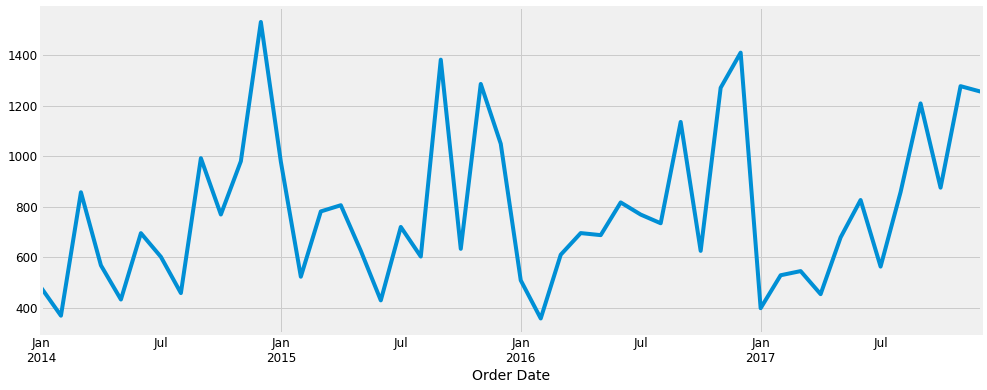

In [10]:
y.plot(figsize=(15, 6))
plt.show()

Когда мы наносим данные на график, появляются некоторые различимые закономерности. Временные ряды имеют сезонный характер, например, продажи всегда низкие в начале года и высокие в конце года. В течение любого года всегда есть восходящий тренд с парой низких месяцев в середине года.  
Мы также можем визуализировать наши данные, используя метод, называемый декомпозицией временных рядов, который позволяет нам разложить наши временные ряды на три отдельных компонента: тренд, сезонность и шум.

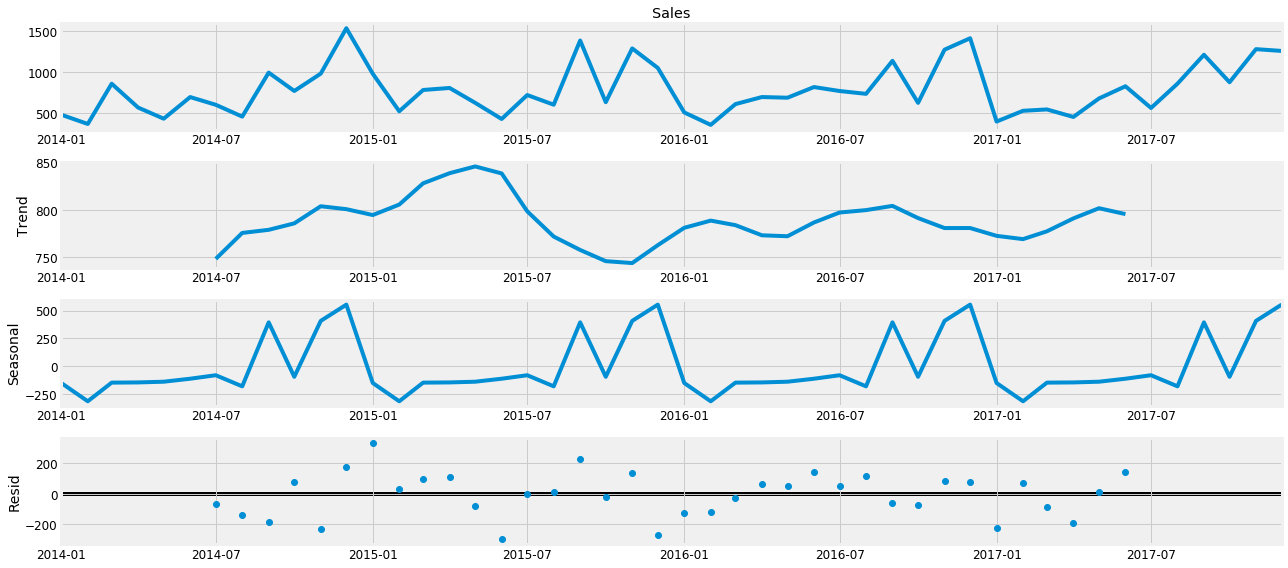

In [11]:
from pylab import rcParams


rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

На графике выше отчетливо видно, что продажи мебели нестабильны при наличии сезонности.

## Прогнозирование временных рядов с помощью ARIMA

Один из наиболее часто используемых методов прогнозирования временных рядов называется ARIMA, что означает авторегрессионное интегрированное скользящее среднее.

Модели ARIMA обозначаются обозначением ARIMA (p, d, q). Эти три параметра учитывают сезонность, тренд и шум в данных:

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Теперь мы подготовим набор параметров для модели временных рядов ARIMA для продаж мебели. Мы будем использовать «поиск по сетке», чтобы найти оптимальный набор параметров, обеспечивающий наилучшую производительность для нашей модели.

In [13]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1395.92721628762
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793829
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1253.2215300525054
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302928
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.92522707581


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2683.315313820134
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732944


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5730681144165


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2557.577481974908
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468646
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576431141
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:755.9267712508868
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.9671228167957
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1132.5784254247974
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.91132001514774
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817054


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2370.9499183016433
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484828255
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233392755
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774427025
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2383.0998935954744
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417307
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612447
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1481.5603433198874
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160949
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935194


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1158.1916450584345
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084607
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438513
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218597


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2681.2673067812148
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958157257
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659176
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876961


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2527.9479662935846
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002146679
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.75131881245176
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1569.080935977904
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.21306116190937
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784957
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1218.5110449764074
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454116
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925188457
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835292


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1415.1311803651824
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610485
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.38730069394074
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546608


c:\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1444.71009969246
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395378553
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661017174718


Приведенный выше результат предполагает, что SARIMAX (1, 1, 1) x (0, 1, 1, 12) дает наименьшее значение AIC 281.38. Поэтому будем считать, что нашли оптимальный вариант и используем этот набор параметров для обучения модели.

In [14]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0953      0.310     -0.307      0.759      -0.703       0.513
ma.L1         -1.0000      0.414     -2.417      0.016      -1.811      -0.189
ma.S.L12      -0.3049      0.172     -1.777      0.076      -0.641       0.031
sigma2      2.476e+04   1.67e-05   1.48e+09      0.000    2.48e+04    2.48e+04


Мы всегда должны запускать диагностику модели, чтобы исследовать любое необычное поведение.

## Проверка прогнозов

Чтобы нам понять точность наших прогнозов, мы сравниваем прогнозируемые продажи с реальными  и устанавливаем прогнозы от начала 2017-го и до конца данных.

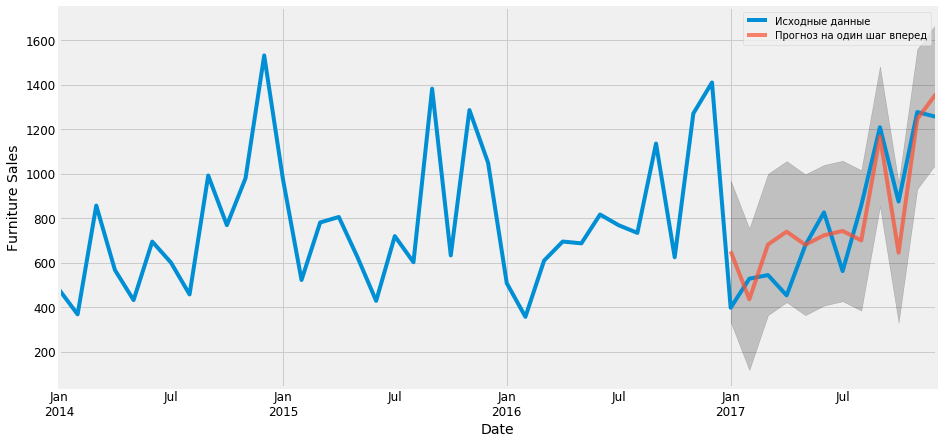

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='Исходные данные')
pred.predicted_mean.plot(ax=ax, label='Прогноз на один шаг вперед', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


Линейный график показывает наблюдаемые значения по сравнению с предсказаниями скользящего прогноза. В целом, наши прогнозы очень хорошо совпадают с истинными значениями, показывая восходящий тренд, начинающийся с начала года и отражающий сезонность к концу года.

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Среднеквадратическая ошибка наших прогнозов составляет {}'.format(round(mse, 2)))

Среднеквадратическая ошибка наших прогнозов составляет 25665.07


In [17]:
print('Корень из среднеквадратической ошибки {}'.format(round(np.sqrt(mse), 2)))

Корень из среднеквадратической ошибки 160.2


В статистике среднеквадратичная ошибка (MSE) оценщика измеряет среднее квадратов ошибок, то есть среднеквадратичную разницу между оцененными значениями и тем, что оценивается. MSE - это мера качества оценки - она всегда неотрицательна, и чем меньше MSE, тем ближе мы к нахождению линии наилучшего соответствия.

Среднеквадратическая ошибка (RMSE) говорит нам, что наша модель смогла спрогнозировать среднесуточные продажи мебели в тестовом наборе в пределах 160.2 от реальных продаж. Ежедневные продажи нашей мебели колеблются от 400 до более 1200. Кажется у нас пока довольно хорошая модель.

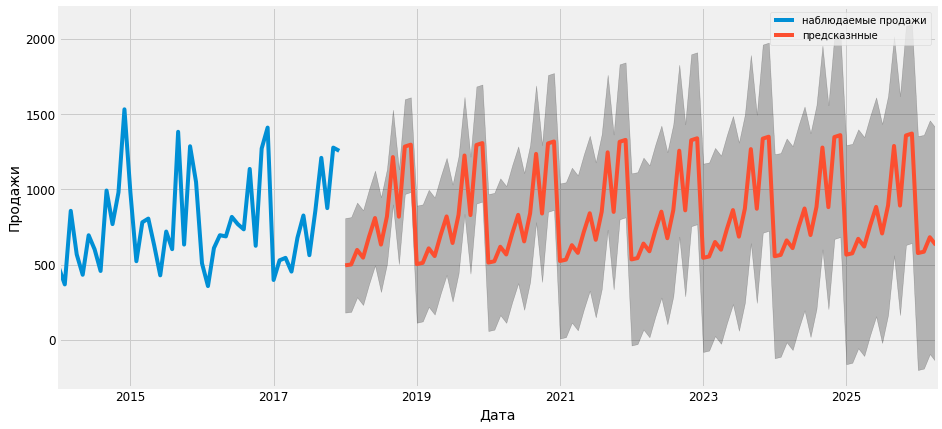

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='наблюдаемые продажи', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='предсказнные')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Дата')
ax.set_ylabel('Продажи')
plt.legend()
plt.show()

Наша модель четко отражает сезонность продаж мебели. По мере того, как мы прогнозируем будущее, для нас естественно терять уверенность в своих ценностях. Это отражается в доверительных интервалах, созданных нашей моделью, которые становятся больше по мере нашего продвижения в будущее.

Приведенный выше анализ временных рядов для мебели заставляет меня интересоваться другими категориями и тем, как они соотносятся друг с другом во времени. Поэтому мы собираемся сравнить временные ряды поставщика мебели и офисных принадлежностей.

In [19]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape


((2121, 21), (6026, 21))

Мы собираемся сравнить продажи двух категорий за один и тот же период времени. Нам понадобится объеденить два датафрейма данных в одино, после чего можно будет отобразить данные временных рядов этих двух категорий на одном графике.

In [20]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Customer Name', 'Segment',
        'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category',
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()


,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


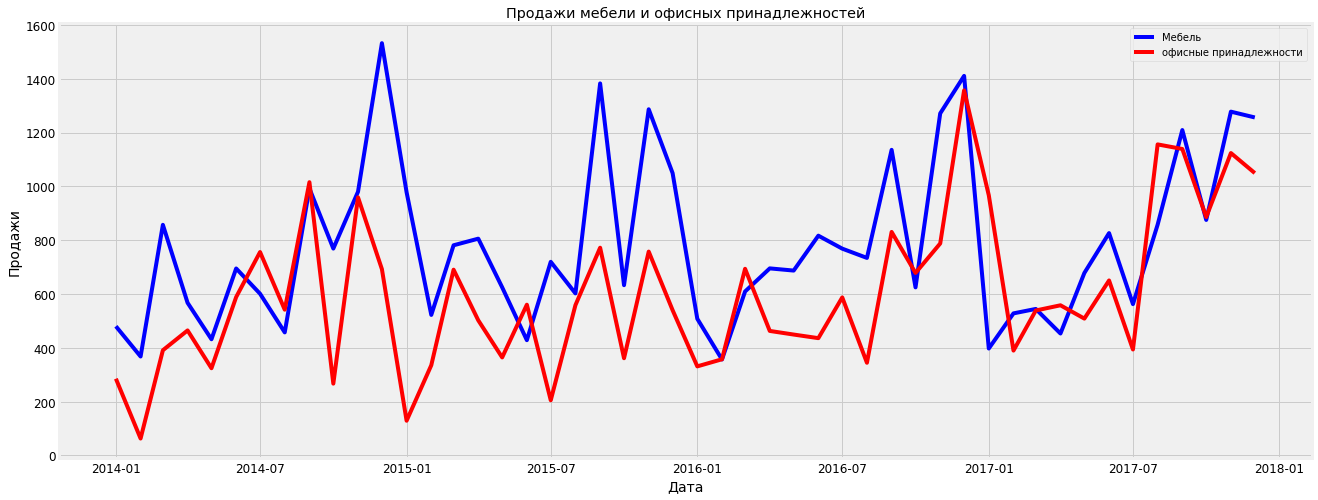

In [21]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Мебель')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'офисные принадлежности')
plt.xlabel('Дата'); plt.ylabel('Продажи'); plt.title('Продажи мебели и офисных принадлежностей')
plt.legend();


## Моделирование временных рядов с помощью Prophet

Выпущенный Facebook в 2017 году инструмент прогнозирования Prophet предназначен для анализа временных рядов, отображающих закономерности в разных временных масштабах, таких как годовой, недельный и ежедневный. Он также имеет расширенные возможности для моделирования влияния праздников на временные ряды и реализации настраиваемых точек изменения. Поэтому мы используем Prophet, чтобы запустить модель.

In [ ]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');


In [ ]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');


## Сравним прогнозы

У нас уже есть прогнозы на три года по этим двум категориям в будущем. Теперь мы присоединимся к ним, чтобы сравнить их прогнозы на будущее.

In [ ]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()


Посмотрим на тренды и прогнозы

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Дата'); plt.ylabel('Продажи')
plt.title('Furniture vs. Office Supplies Sales Trend');

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');


Тенденции и паттерны

Теперь мы можем использовать модели Prothet для проверки различных тенденций для наших категорий товаров.

In [ ]:
furniture_model.plot_components(furniture_forecast);

In [ ]:
office_model.plot_components(office_forecast);

Приятно видеть, что продажи как мебели, так и канцелярских товаров линейно растут с течением времени и будут продолжать расти, хотя рост продаж канцелярских товаров кажется немного более сильным.

Худший месяц для мебели - апрель, худший месяц для канцелярских товаров - февраль. Лучший месяц для мебели - декабрь, а лучший месяц для канцелярских товаров - октябрь.